In [27]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np
import tensorflow.compat.v1 as tf
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b

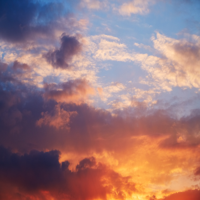

In [66]:
height = 200
width = 200

content_image_path = 'sky2.jpeg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image


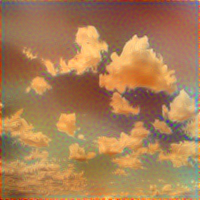

In [67]:
style_image_path = 'sky3.png'
style_image = Image.open (style_image_path)
style_image = style_image.resize((height, width))
style_image

In [68]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 200, 200, 3)
(1, 200, 200, 3)


In [69]:
content_array[:,:,:,0] -= 100.99
content_array[:, :, :, 1] -= 110.779
content_array[:, :, :, 2] -= 150.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 100.939
style_array[:, :, :, 1] -= 110.779
style_array[:, :, :, 2] -= 150.68
style_array = style_array[:, :, :, ::-1]

In [70]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

In [71]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis = 0)

In [72]:
import h5py
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

In [73]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'input_3': <tf.Tensor 'concat_2:0' shape=(3, 200, 200, 3) dtype=float32>,
 'block1_conv1': <tf.Tensor 'block1_conv1_2/Relu:0' shape=(3, 200, 200, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_2/Relu:0' shape=(3, 200, 200, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_2/MaxPool:0' shape=(3, 100, 100, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_2/Relu:0' shape=(3, 100, 100, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_2/Relu:0' shape=(3, 100, 100, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_2/MaxPool:0' shape=(3, 50, 50, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_2/Relu:0' shape=(3, 50, 50, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_2/Relu:0' shape=(3, 50, 50, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_2/Relu:0' shape=(3, 50, 50, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_2/MaxPool:0' shape=(3, 25, 25, 256) dtype=float32>,
 'blo

In [74]:
content_weight = 0.2
style_weight = 6.0
total_variation_weight = 2.0

In [75]:
 loss = backend.variable(0.)

In [76]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss = loss + content_weight * content_loss(content_image_features,
                                      combination_features)

In [77]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl

In [78]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

In [79]:
grads = backend.gradients(loss, combination_image)

In [80]:
outputs = [loss]
outputs = outputs + grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
     x = x.reshape((1, height, width, 3))
     outs = f_outputs([x])
     loss_value = outs[0]
     grad_values = outs[1].flatten().astype('float64')
     return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [81]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 6

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 62003364000.0
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 14749667000.0
Iteration 1 completed in 19s
Start of iteration 2
Current loss value: 6915444000.0
Iteration 2 completed in 19s
Start of iteration 3
Current loss value: 4861850000.0
Iteration 3 completed in 20s
Start of iteration 4
Current loss value: 3732565800.0
Iteration 4 completed in 25s
Start of iteration 5
Current loss value: 3226105900.0
Iteration 5 completed in 29s


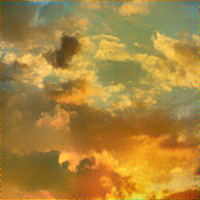

In [82]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)